# **[BIKE SHARING](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset)**

### Librerias

In [21]:
import os
import random
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


### Carga de datos

In [7]:
# Cambia a 'hour' si quieres trabajar por hora
CSV = "day"   # 'day' o 'hour'

if CSV == "day":
    CSV_PATH = "dataset/day.csv"  
else:
    CSV_PATH = "dataset/hour.csv"

df = pd.read_csv(CSV_PATH)

df.head(5)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


### Seleccion de variables

In [10]:
DROP_COLS = ["instant", "dteday", "casual", "registered"]
DROP_COLS = [c for c in DROP_COLS if c in df.columns]

df = df.drop(columns=DROP_COLS)

X = df.drop(columns=["cnt"])
y = df["cnt"].astype("float32")

cat_cols = ["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit"]
if "hr" in X.columns:
    cat_cols.append("hr")

num_cols = [c for c in X.columns if c not in cat_cols]

print("Categoricas:", cat_cols)
print("Numericas:", num_cols)


Categoricas: ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
Numericas: ['temp', 'atemp', 'hum', 'windspeed']


### Separacion 

In [11]:
stratify_labels = X["yr"] if "yr" in X.columns else None

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=stratify_labels
)

stratify_labels_temp = X_temp["yr"] if "yr" in X_temp.columns else None

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=SEED, stratify=stratify_labels_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (438, 11) Val: (146, 11) Test: (147, 11)


### One-Hot + Escalado

In [13]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False) if "sparse_output" in OneHotEncoder().get_params() \
      else OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    remainder="drop"
)

preprocess.fit(X_train)

X_train_p = preprocess.transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

input_dim = X_train_p.shape[1]


### Modelo MLP

In [15]:
def build_mlp(input_dim: int) -> keras.Model:
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64,  activation="relu"),
        layers.Dense(1,   activation="linear"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

model = build_mlp(input_dim)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [16]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 24560870.0000 - mae: 4555.4961 - val_loss: 23536482.0000 - val_mae: 4418.4624 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24552924.0000 - mae: 4554.6069 - val_loss: 23527936.0000 - val_mae: 4417.4717 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24542924.0000 - mae: 4553.4956 - val_loss: 23516414.0000 - val_mae: 4416.1499 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24528852.0000 - mae: 4551.9434 - val_loss: 23499716.0000 - val_mae: 4414.2578 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24508260.0000 - mae: 4549.6938 - val_loss: 23475292.0000 - val_mae: 4411.5225 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24478496.0000 - mae: 4546.4697 - val_loss: 23440420.0000 - val_mae: 4407.6499 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/s

### Evaluacion

In [19]:
def evaluate_regression(y_true, y_pred, name=""):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"[{name}] MAE={mae:.4f} | RMSE={rmse:.4f} | R2={r2:.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


y_val_pred  = model.predict(X_val_p,  verbose=0).ravel()
y_test_pred = model.predict(X_test_p, verbose=0).ravel()

metrics_val  = evaluate_regression(y_val,  y_val_pred,  name="Validación")
metrics_test = evaluate_regression(y_test, y_test_pred, name="Test")

# Tabla de métricas
metrics_df = pd.DataFrame([metrics_val, metrics_test], index=["Validación", "Test"])
print(metrics_df)

[Validación] MAE=616.5153 | RMSE=906.8790 | R2=0.7951
[Test] MAE=533.6090 | RMSE=728.6956 | R2=0.8383
                   MAE        RMSE        R2
Validación  616.515320  906.879023  0.795077
Test        533.609009  728.695624  0.838295


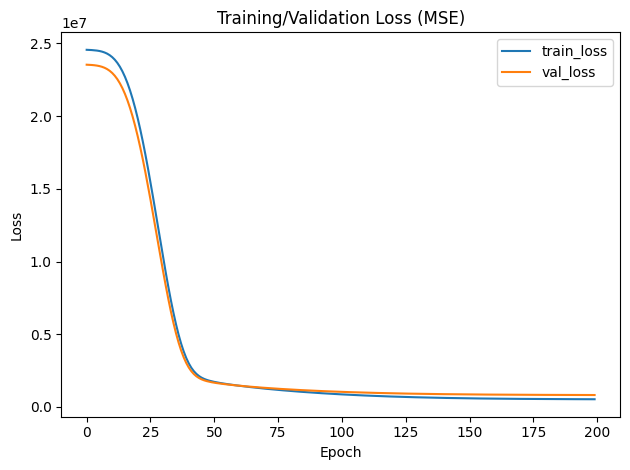

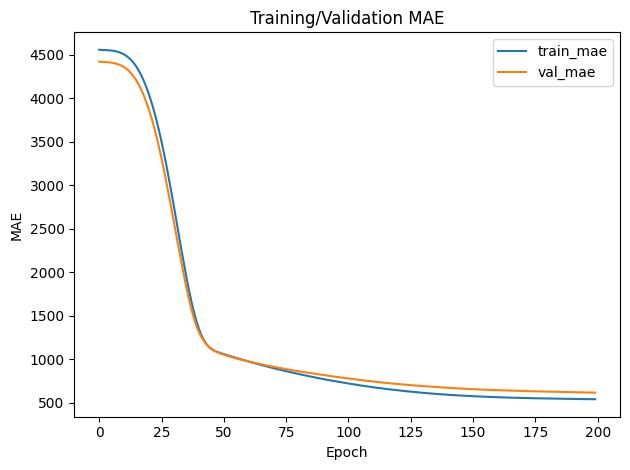

In [ ]:
train_loss = history.history.get("loss", [])
val_loss   = history.history.get("val_loss", [])
train_mae  = history.history.get("mae", [])
val_mae    = history.history.get("val_mae", [])

plt.figure()
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss,   label="val_loss")
plt.title("Training/Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

if len(train_mae) and len(val_mae):
    plt.figure()
    plt.plot(train_mae, label="train_mae")
    plt.plot(val_mae,   label="val_mae")
    plt.title("Training/Validation MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

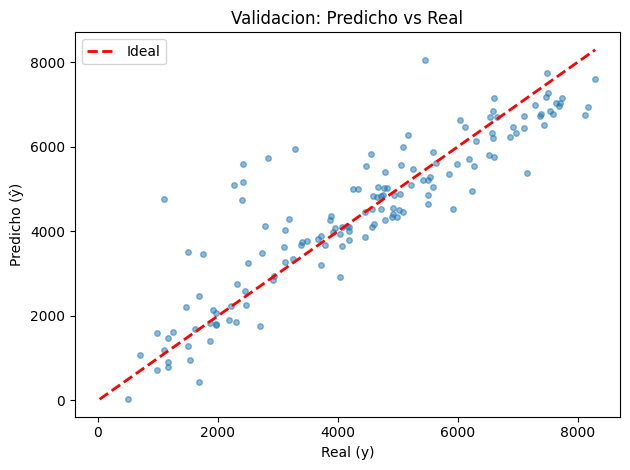

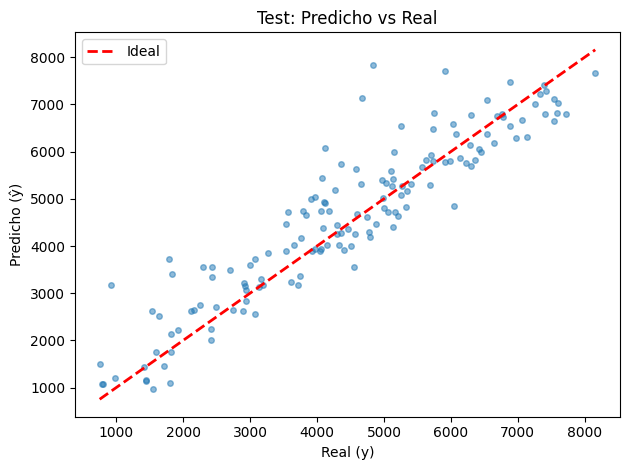

In [ ]:
if "y_val_pred" not in globals():
    y_val_pred = model.predict(X_val_p, verbose=0).ravel()
if "y_test_pred" not in globals():
    y_test_pred = model.predict(X_test_p, verbose=0).ravel()

def scatter_pred_true(y_true, y_pred, title):
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.figure()
    plt.scatter(y_true, y_pred, s=16, alpha=0.5)
    plt.plot(lims, lims, "r--", lw=2, label="Ideal")
    plt.title(title)
    plt.xlabel("Real (y)")
    plt.ylabel("Predicho (ŷ)")
    plt.legend()
    plt.tight_layout()
    plt.show()

scatter_pred_true(y_val,  y_val_pred,  "Validacion: Predicho vs Real")
scatter_pred_true(y_test, y_test_pred, "Test: Predicho vs Real")